In [12]:
import numpy as np
import pandas as pd
import operator
import pickle
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, cross_validation
from sklearn.cross_validation import train_test_split
from sklearn import linear_model

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler, SMOTE
import warnings
warnings.filterwarnings(action='once')
from sklearn.model_selection import StratifiedKFold
from scipy import interp
from itertools import cycle
import seaborn as sns

In [49]:
data = pd.read_pickle('../../Data/Opioids/Model_Data/Age_Condensed/data.pickle')

In [50]:
data_req = data[['GENDER', 'EXPIRE_FLAG', 'TOTAL_NARCOTIC_PRESCRIPTONS',
       'TOTAL_ANTI_NARCOTIC_PRESCRIPTONS', 'NARCOTIC', 'ANTI-NARCOTIC',
       'ICU_STAY', 'OXYMORPHONE', 'OXYCODONE', 'MORPHINE', 'MEPERIDINE',
       'HYDROMORPHONE', 'HYDROCODONE', 'FENTANYL', 'CODEINE', 'BUPRENORPHINE',
       'METHADONE', 'NALOXONE', 'AGE_3', 'AGE_4', 'AGE_5', 'AGE_6', 'SIDE_EFFECTS_FLAG']]

X = data[['GENDER', 'EXPIRE_FLAG', 'TOTAL_NARCOTIC_PRESCRIPTONS',
       'TOTAL_ANTI_NARCOTIC_PRESCRIPTONS', 'NARCOTIC', 'ANTI-NARCOTIC',
       'ICU_STAY', 'OXYMORPHONE', 'OXYCODONE', 'MORPHINE', 'MEPERIDINE',
       'HYDROMORPHONE', 'HYDROCODONE', 'FENTANYL', 'CODEINE', 'BUPRENORPHINE',
       'METHADONE', 'NALOXONE', 'AGE_3', 'AGE_4', 'AGE_5', 'AGE_6']]
y = data[['SIDE_EFFECTS_FLAG']]
y = y.as_matrix()
y = y.reshape(20703,)

### Observing The Correlation of Features - Original Data

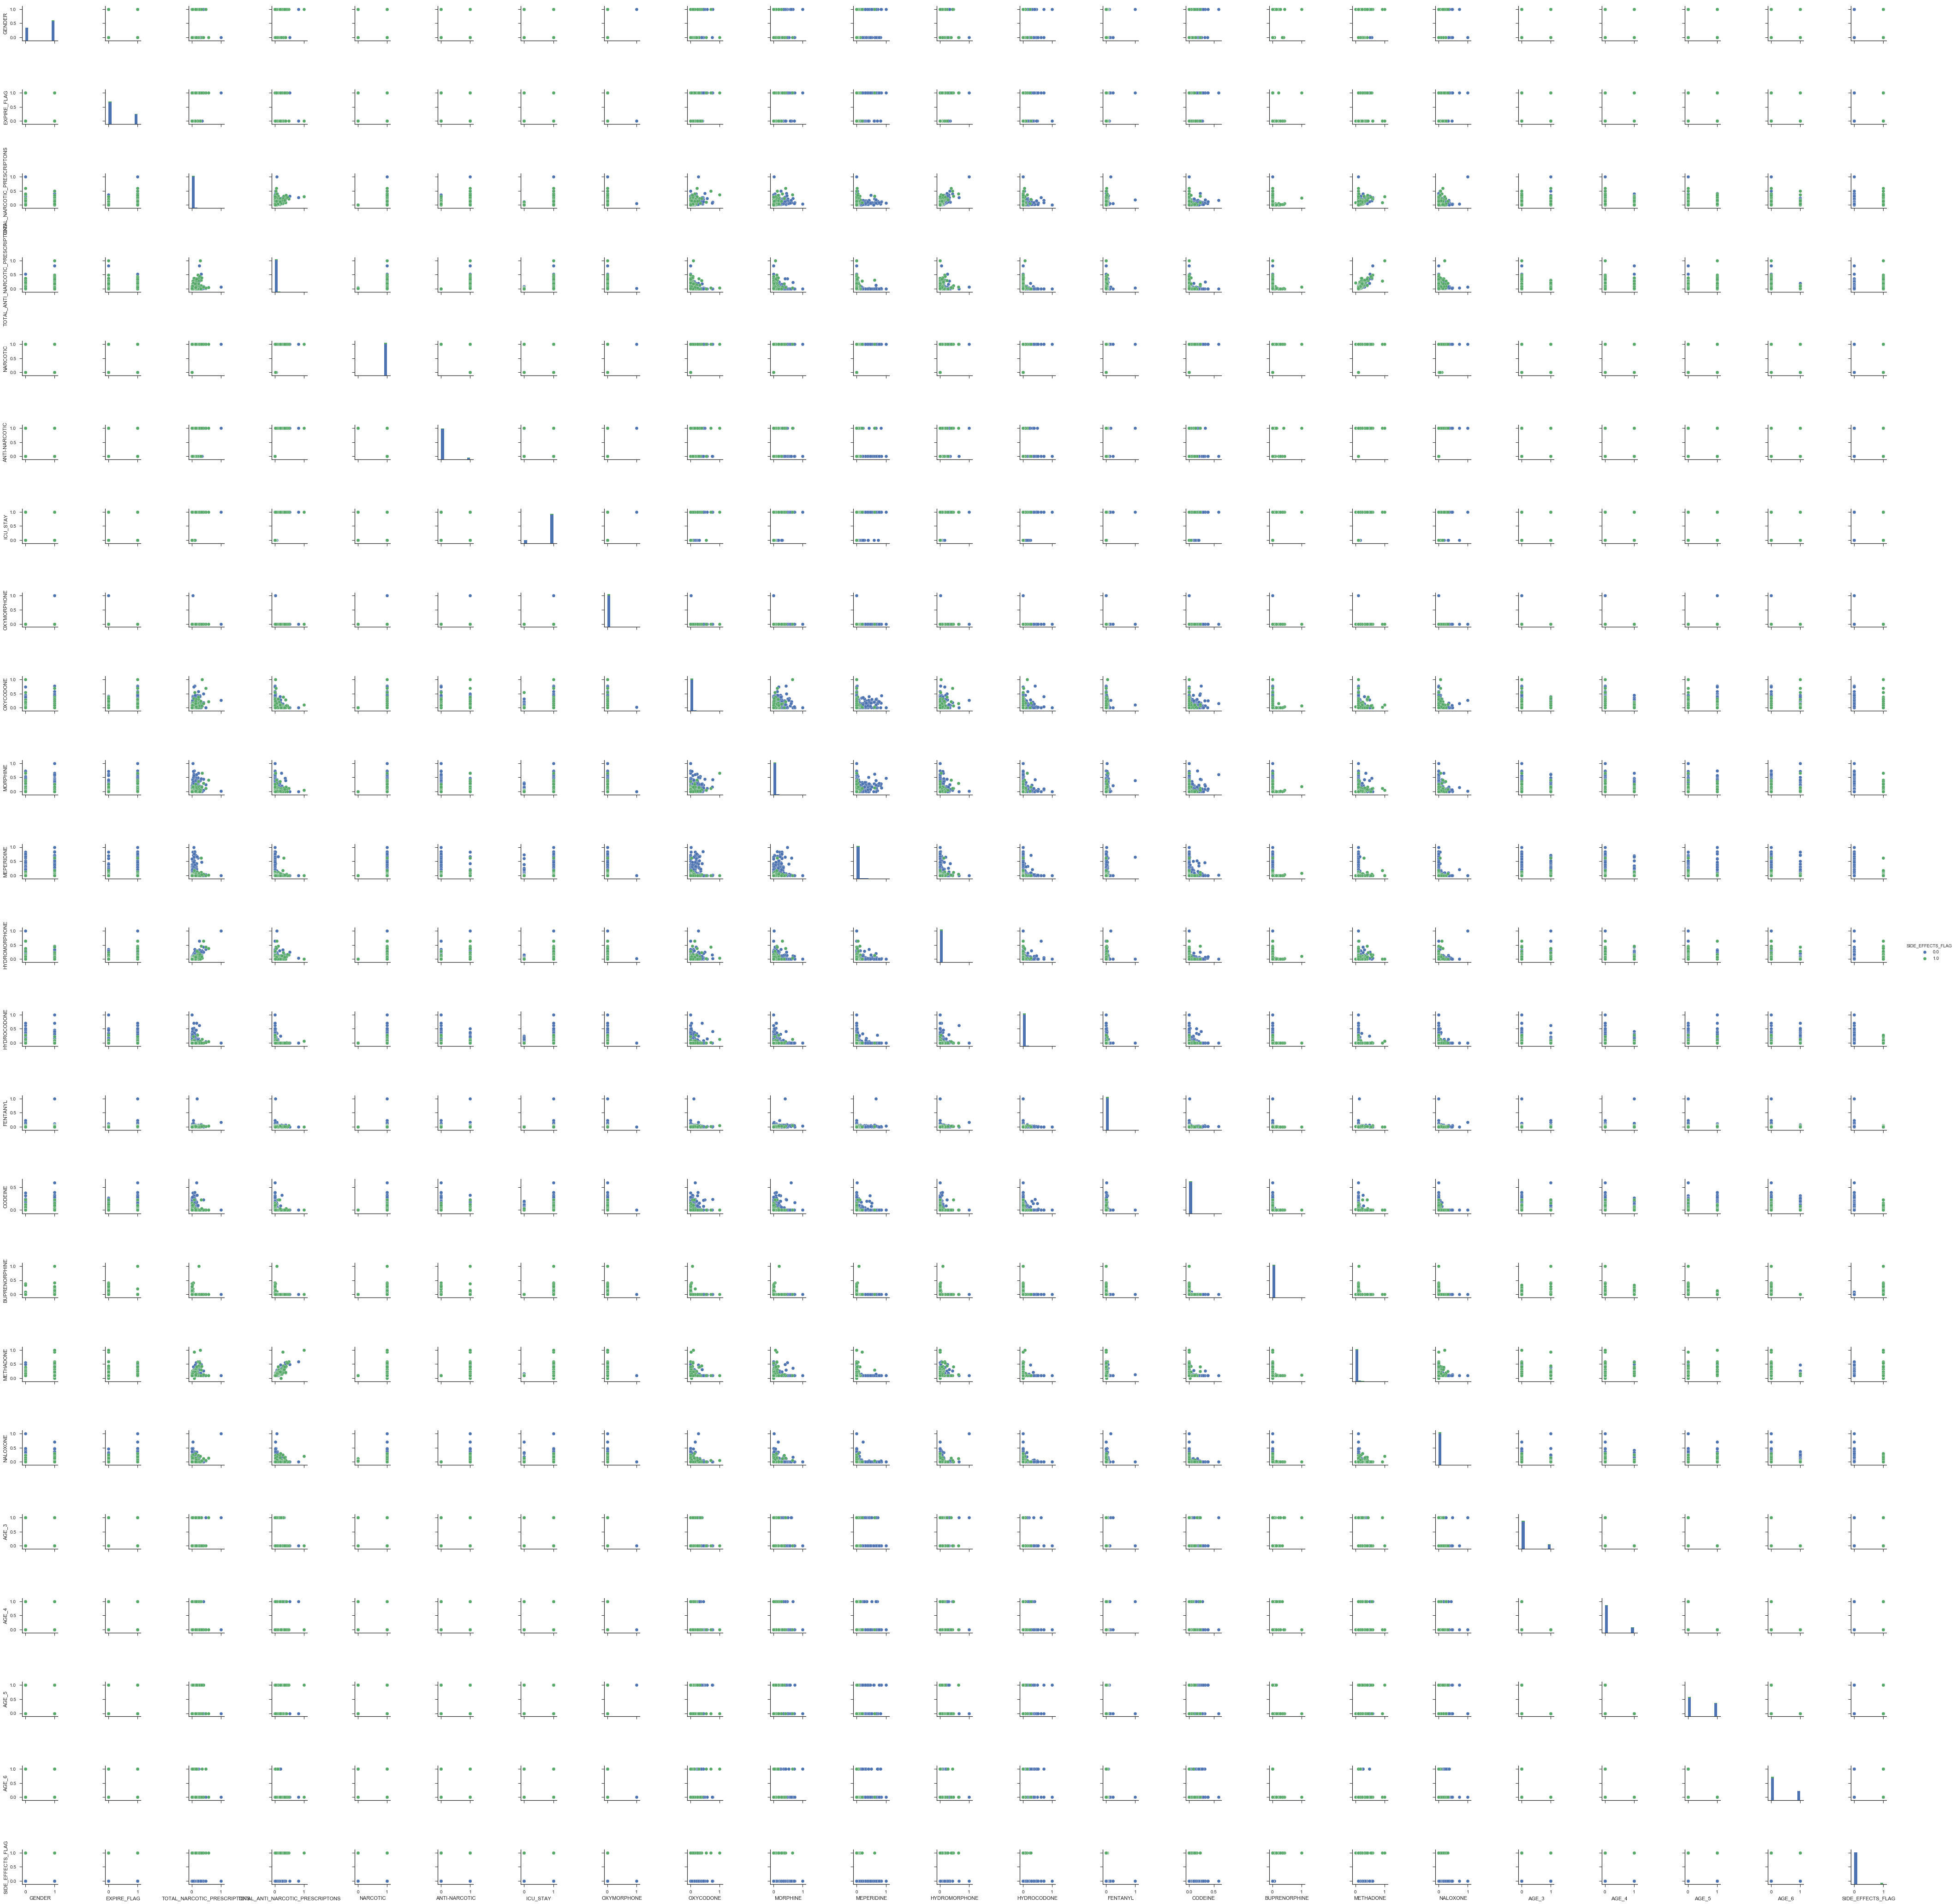

In [19]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(data_req, hue="SIDE_EFFECTS_FLAG")
plt.savefig('scatterplot_matrix_original_data.png')

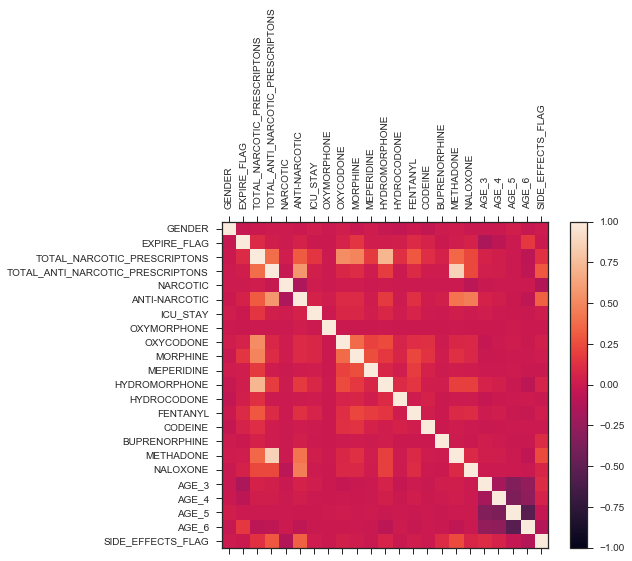

In [88]:
correlations = data_req.corr()
# plot correlation matrix
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data_req.columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(data_req.columns, rotation='vertical')
ax.set_yticklabels(data_req.columns)
plt.show()

In [90]:
print(data_req.describe())

             GENDER   EXPIRE_FLAG  TOTAL_NARCOTIC_PRESCRIPTONS  \
count  20703.000000  20703.000000                 20703.000000   
mean       0.606530      0.308748                     0.020614   
std        0.488531      0.461988                     0.026521   
min        0.000000      0.000000                     0.000000   
25%        0.000000      0.000000                     0.007614   
50%        1.000000      0.000000                     0.012690   
75%        1.000000      1.000000                     0.022843   
max        1.000000      1.000000                     1.000000   

       TOTAL_ANTI_NARCOTIC_PRESCRIPTONS      NARCOTIC  ANTI-NARCOTIC  \
count                      20703.000000  20703.000000   20703.000000   
mean                           0.003037      0.998841       0.058059   
std                            0.021376      0.034029       0.233861   
min                            0.000000      0.000000       0.000000   
25%                            0.000000      

In [92]:
'''rho = data_req.corr()
pval = rho.copy()
for i in range(data_req.shape[1]): # rows are the number of rows in the matrix.
    for j in range(data_req.shape[1]):
        try:
            ols_df = pd.ols(y=data_req.iloc[:,i], x=data_req.iloc[:,j], intercept=True)
            pval.iloc[i,j]  = ols_df.f_stat['p-value']
        except ValueError:
            pval.iloc[i,j]  = None
pval'''

"rho = data_req.corr()\npval = rho.copy()\nfor i in range(data_req.shape[1]): # rows are the number of rows in the matrix.\n    for j in range(data_req.shape[1]):\n        try:\n            ols_df = pd.ols(y=data_req.iloc[:,i], x=data_req.iloc[:,j], intercept=True)\n            pval.iloc[i,j]  = ols_df.f_stat['p-value']\n        except ValueError:\n            pval.iloc[i,j]  = None\npval"

### Performing PCA After OverSampling With SMOTE 
Initially PCA component is taken as 1 to visualize data in 2D.

In [53]:
# Instanciate a PCA object for the sake of easy visualisation
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X)

sampler = SMOTE()
X_resampled, y_resampled = sampler.fit_sample(X, y)
X_res_vis = pca_vis.transform(X_resampled)

In [69]:
y_series = pd.Series(y)
y_series = y_series.map({0.0:'A', 1.0:'P'})
y_df = pd.DataFrame(columns=["TARGET"])
y_df["TARGET"] = y_series
y_df["TARGET"] = y_df["TARGET"].astype('category', categories=['A','P'])
y_enc = pd.get_dummies(y_df["TARGET"])
y_enc.columns=["ABSENT", "PRESENT"]
y_enc.head()
y_vis = y_enc.as_matrix()
len(y_vis)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


20703

In [71]:
y_resampled_series = pd.Series(y_resampled)
y_resampled_series = y_resampled_series.map({0.0:'A', 1.0:'P'})
y_df = pd.DataFrame(columns=["TARGET"])
y_df["TARGET"] = y_resampled_series
y_df["TARGET"] = y_df["TARGET"].astype('category', categories=['A','P'])
y_enc = pd.get_dummies(y_df["TARGET"])
y_enc.columns=["ABSENT", "PRESENT"]
y_enc.head()
y_res_vis = y_enc.as_matrix()
len(y_res_vis)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


39938

In [74]:
len(X_vis[y_vis == 0])

20703

In [43]:
#print(pca.components_)
print(pca_vis.explained_variance_ratio_)

[0.26783969 0.18917635]
